In [15]:
!pip install keras-tuner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, Attention, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import Ridge
import xgboost as xgb
import keras_tuner as kt
from google.colab import files

# Load Dataset
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(list(uploaded.keys())[0])

# Data Preprocessing
data = data.dropna()
dates = pd.to_datetime(data['Trade Date'], dayfirst=False, errors='coerce')


Saving Merged file 1proj.csv to Merged file 1proj (2).csv


In [18]:
def calculate_technical_indicators(data):
    data['EMA_7'] = data['Close '].ewm(span=7, adjust=False).mean()
    data['EMA_14'] = data['Close '].ewm(span=14, adjust=False).mean()
    data['SMA_7'] = data['Close '].rolling(window=7).mean()
    data['MACD'] = data['Close '].ewm(span=12, adjust=False).mean() - data['Close '].ewm(span=26, adjust=False).mean()
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['Momentum'] = data['Close '] - data['Close '].shift(4)
    data['Bollinger_Mid'] = data['Close '].rolling(window=20).mean()
    data['Bollinger_Std'] = data['Close '].rolling(window=20).std()
    data['Bollinger_Upper'] = data['Bollinger_Mid'] + (2 * data['Bollinger_Std'])
    data['Bollinger_Lower'] = data['Bollinger_Mid'] - (2 * data['Bollinger_Std'])
    delta = data['Close '].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data
    # Add indicators
data = calculate_technical_indicators(data).dropna().reset_index(drop=True)
dates = dates.iloc[-len(data):].reset_index(drop=True)

technical_indicators = ['EMA_7', 'EMA_14', 'SMA_7', 'MACD', 'MACD_Signal',
                        'Momentum', 'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI']

print("\nCorrelation of Technical Indicators with Close Price:\n")
for indicator in technical_indicators:
    correlation = data['Close '].corr(data[indicator])
    print(f"{indicator}: {correlation:.4f}")



Correlation of Technical Indicators with Close Price:

EMA_7: 0.7965
EMA_14: 0.6642
SMA_7: 0.6089
MACD: 0.6550
MACD_Signal: 0.2537
Momentum: 0.6147
Bollinger_Mid: 0.5436
Bollinger_Upper: 0.4452
Bollinger_Lower: 0.0776
RSI: 0.5506


Trial 5 Complete [00h 00m 15s]
val_loss: 313.7583923339844

Best val_loss So Far: 259.2485656738281
Total elapsed time: 00h 01m 16s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Optimized XGBoost - MAE: 6.3441, RMSE: 8.8655, R^2: 0.9992
Optimized Neural Network - MAE: 9.0132, RMSE: 12.6123, R^2: 0.9984
Weighted Ensemble - MAE: 6.4747, RMSE: 8.4226, R^2: 0.9993
Stacked Model - MAE: 5.9494, RMSE: 7.9829, R^2: 0.9993


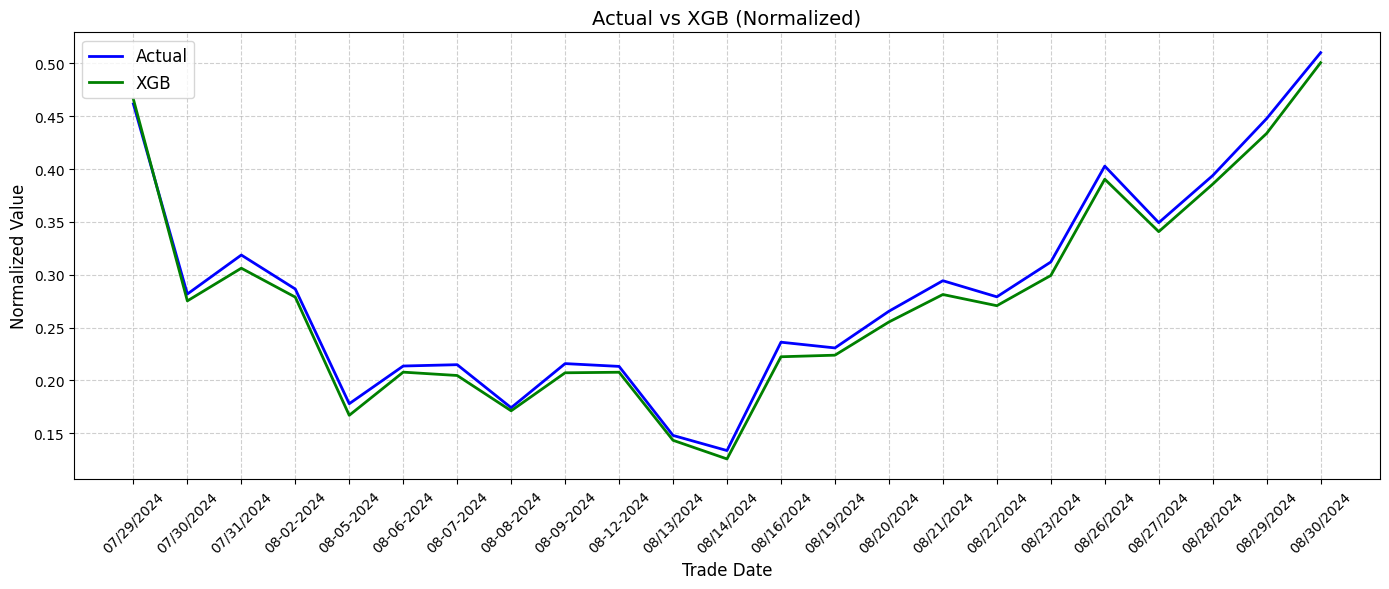

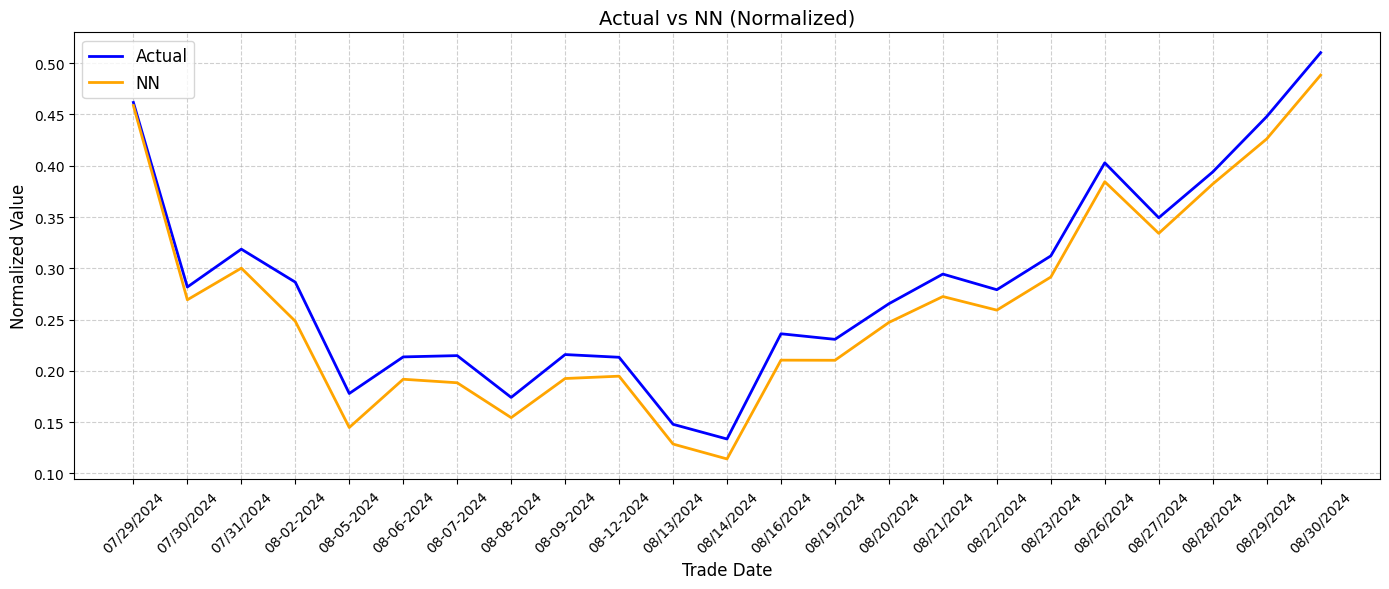

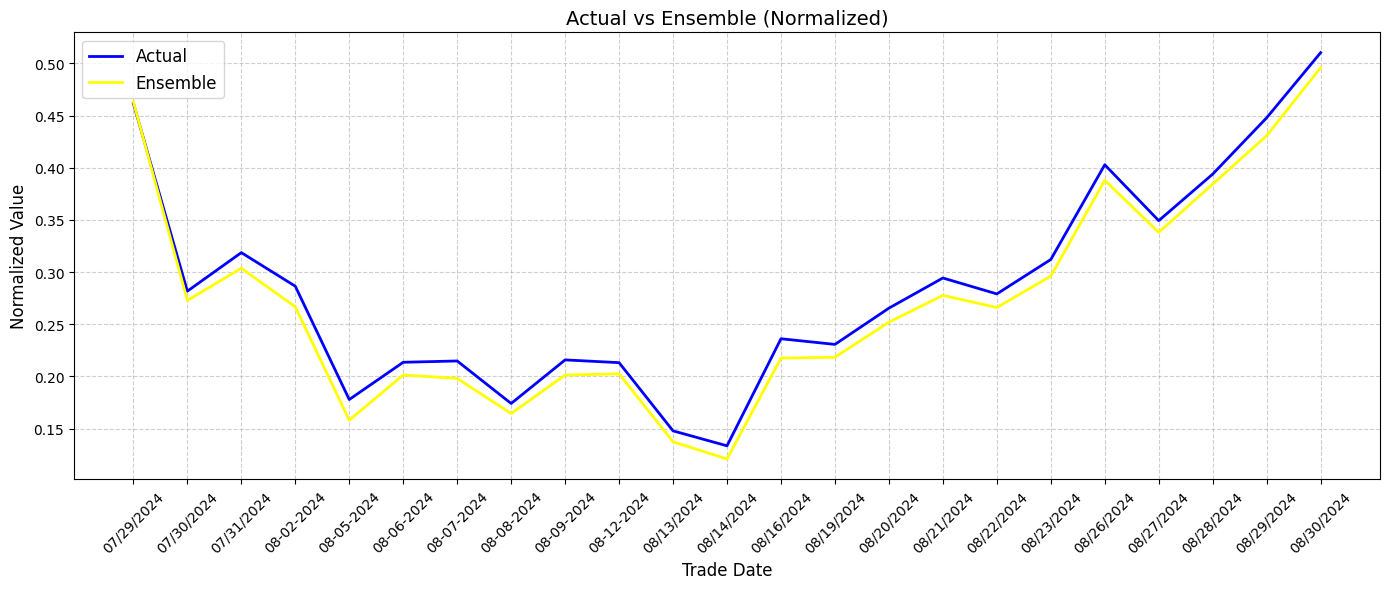

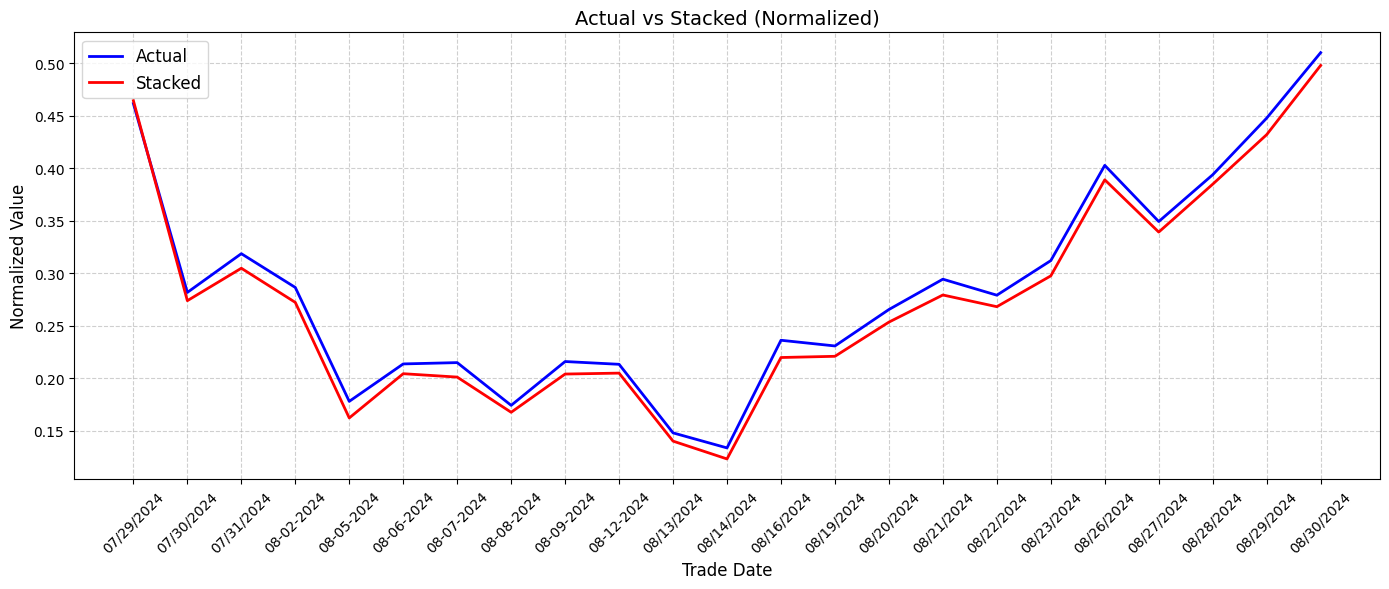

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Reloading Tuner from nn_tuning/nn_tuning_project/tuner0.json
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Optimized XGBoost - MAE: 6.3441, RMSE: 8.8655, R^2: 0.9992
Optimized Neural Network - MAE: 9.0132, RMSE: 12.6123, R^2: 0.9984
Weighted Ensemble - MAE: 6.4747, RMSE: 8.4226, R^2: 0.9993
Stacked Model - MAE: 5.9494, RMSE: 7.9829, R^2: 0.9993


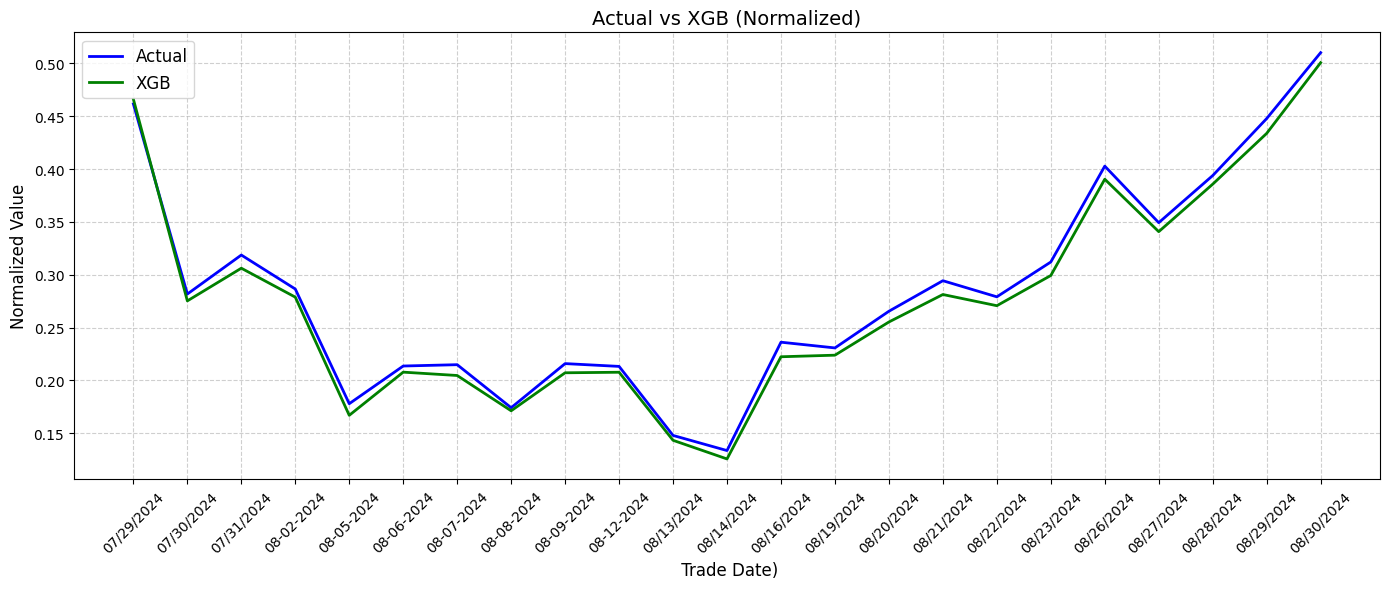

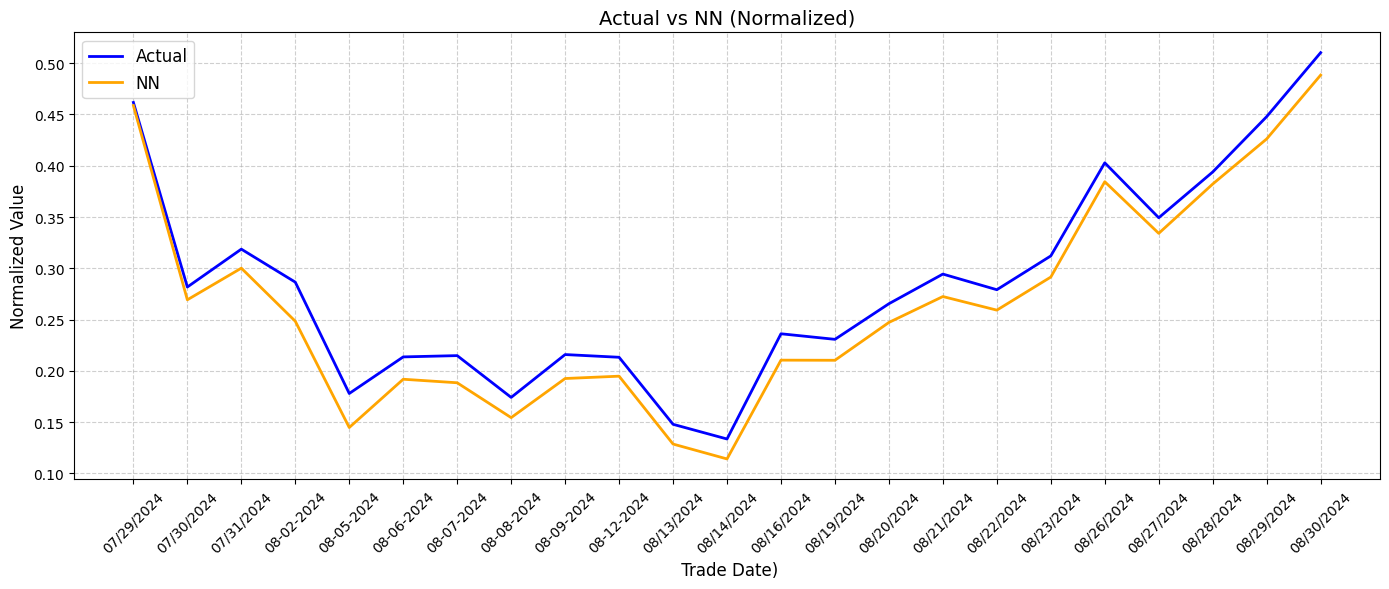

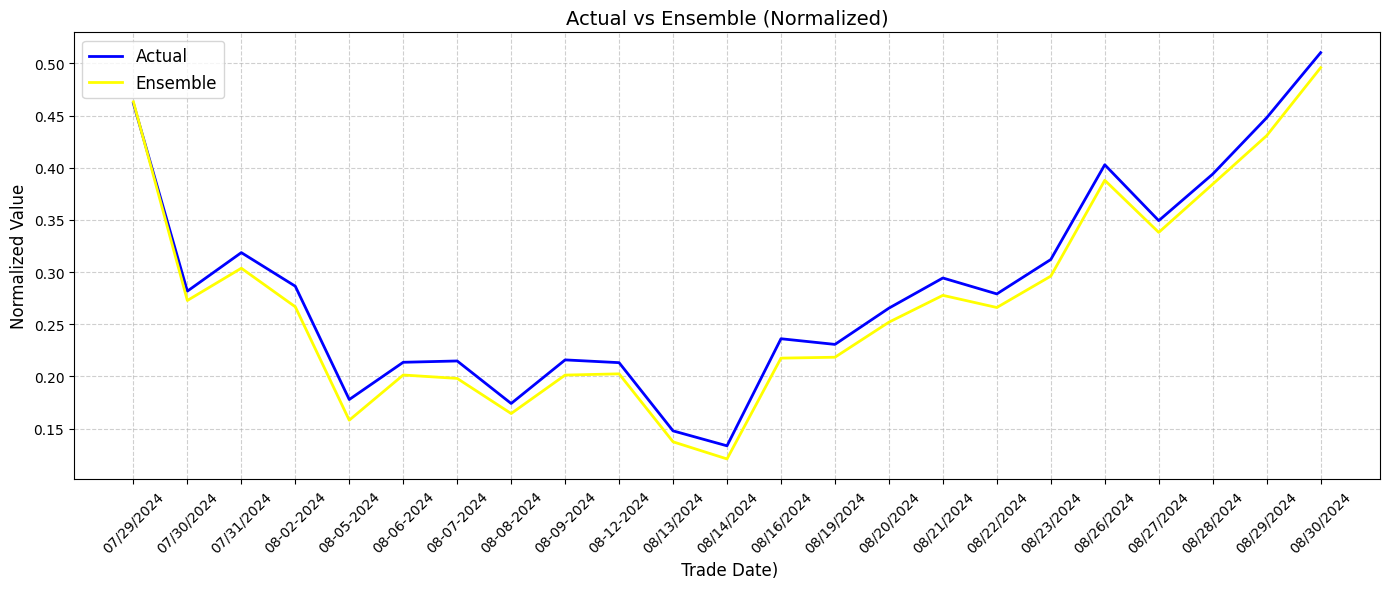

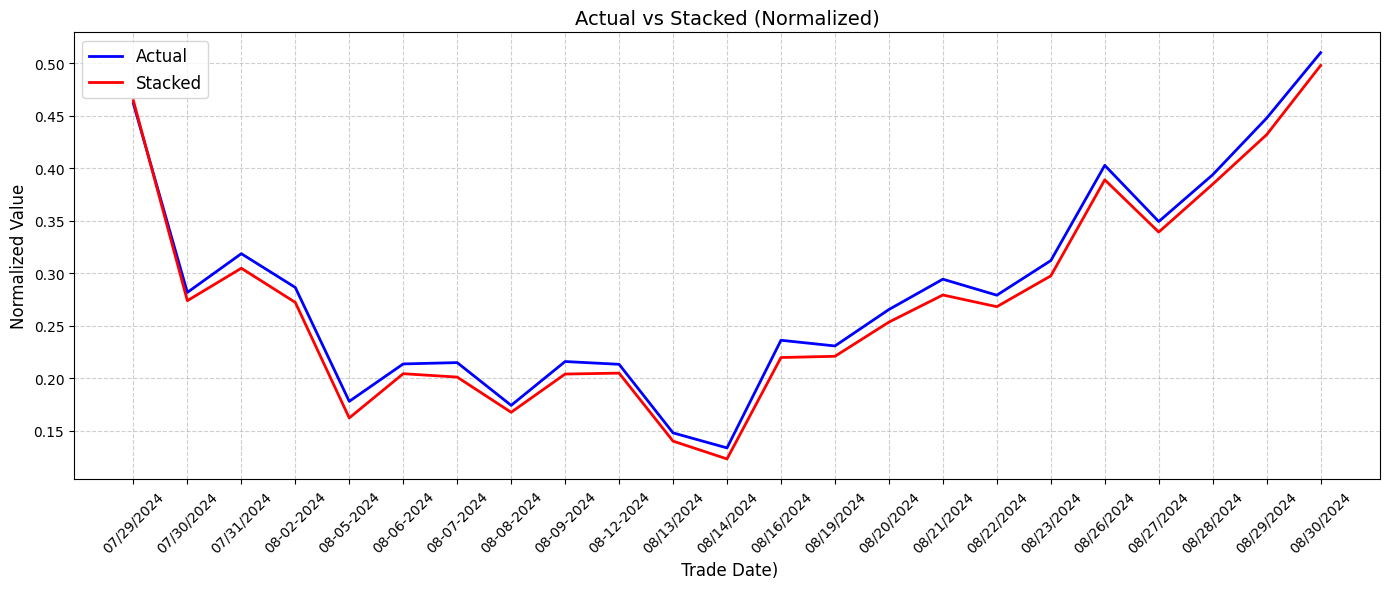

In [21]:
 # Define features and target whose correlation > 0.6
features = ['STRIKE PRICE ', 'OPEN PRICE ', 'HIGH PRICE ', 'LOW PRICE ', 'Close ', 'Volume ',
            'EMA_7', 'EMA_14', 'SMA_7', 'MACD' , 'Momentum']

X = data[features]
y = data['Close ']
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (no shuffle to preserve sequence)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# Get corresponding dates for train and test sets
dates_train = dates[:len(X_train)]
dates_test = dates[len(X_train):]

# Further split train into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# Get corresponding dates for train and validation sets
dates_train = dates_train[:len(X_train)]
dates_val = dates_train[len(X_train):]

# --- Evaluation Function ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")

# --- XGBoost Model ---
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05],
    'max_depth': [2, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.5, 1.0],
    'reg_lambda': [1.0, 2.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3, verbose=1
)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

xgb_preds_test = best_xgb_model.predict(X_test)


# --- Neural Network Model with Keras Tuner ---
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
def build_nn_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 32, 96, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units_2', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3])),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_nn_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='nn_tuning',
    project_name='nn_tuning_project'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

best_nn_model = tuner.get_best_models(num_models=1)[0]
nn_preds_test = best_nn_model.predict(X_test).ravel()

# --- Weighted Ensemble ---
ensemble_test_preds = 0.6 * xgb_preds_test + 0.4 * nn_preds_test

# --- Stacking (Ridge Regression) ---
from sklearn.linear_model import Ridge
stack_test = np.column_stack((xgb_preds_test, nn_preds_test))
ridge_model = Ridge(alpha=10.0)
ridge_model.fit(stack_test, y_test)
stack_preds_test = ridge_model.predict(stack_test)

evaluate(y_test, xgb_preds_test, "Optimized XGBoost")
evaluate(y_test, nn_preds_test, "Optimized Neural Network")
evaluate(y_test, ensemble_test_preds, "Weighted Ensemble")
evaluate(y_test, stack_preds_test, "Stacked Model")
import matplotlib.pyplot as plt
import pandas as pd

# Normalize actual and predicted values
y_test_norm = (y_test - y_test.min()) / (y_test.max() - y_test.min())
xgb_preds_test_norm = (xgb_preds_test - xgb_preds_test.min()) / (xgb_preds_test.max() - xgb_preds_test.min())
nn_preds_test_norm = (nn_preds_test - nn_preds_test.min()) / (nn_preds_test.max() - nn_preds_test.min())
ensemble_test_preds_norm = (ensemble_test_preds - ensemble_test_preds.min()) / (ensemble_test_preds.max() - ensemble_test_preds.min())
stack_preds_test_norm = (stack_preds_test - stack_preds_test.min()) / (stack_preds_test.max() - stack_preds_test.min())

# Prepare the date index (last len(y_test) dates from your dataset)
dates = data['Trade Date'][-len(y_test):].reset_index(drop=True)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'Trade Date': dates,
    'Actual': y_test_norm.reset_index(drop=True),
    'XGB': xgb_preds_test_norm,
    'NN': nn_preds_test_norm,
    'Ensemble': ensemble_test_preds_norm,
    'Stacked': stack_preds_test_norm
})

# Group by Date (if duplicates) and take mean
plot_df = plot_df.groupby('Trade Date').mean().reset_index()

# Plot Actual vs Each Model on separate figures
models = ['XGB', 'NN', 'Ensemble', 'Stacked']
colors = ['green', 'orange', 'yellow', 'red']

for model, color in zip(models, colors):
    plt.figure(figsize=(14, 6))  # Wider figure
    plt.plot(plot_df['Trade Date'], plot_df['Actual'], label='Actual', color='blue', linewidth=2)
    plt.plot(plot_df['Trade Date'], plot_df[model], label=model, color=color, linewidth=2)
    plt.xlabel('Trade Date', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.title(f'Actual vs {model} (Normalized)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()
# Split data (no shuffle to preserve sequence)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# Get corresponding dates for train and test sets
dates_train = dates[:len(X_train)]
dates_test = dates[len(X_train):]

# Further split train into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# Get corresponding dates for train and validation sets
dates_train = dates_train[:len(X_train)]
dates_val = dates_train[len(X_train):]

# --- Evaluation Function ---
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")

# --- XGBoost Model ---
xgb_model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05],
    'max_depth': [2, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.5, 1.0],
    'reg_lambda': [1.0, 2.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3, verbose=1
)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

xgb_preds_test = best_xgb_model.predict(X_test)


# --- Neural Network Model with Keras Tuner ---
def build_nn_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 32, 96, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units_2', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3])),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_nn_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='nn_tuning',
    project_name='nn_tuning_project'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

best_nn_model = tuner.get_best_models(num_models=1)[0]
nn_preds_test = best_nn_model.predict(X_test).ravel()

# --- Weighted Ensemble ---
ensemble_test_preds = 0.6 * xgb_preds_test + 0.4 * nn_preds_test

# --- Stacking (Ridge Regression) ---
stack_test = np.column_stack((xgb_preds_test, nn_preds_test))
ridge_model = Ridge(alpha=10.0)
ridge_model.fit(stack_test, y_test)
stack_preds_test = ridge_model.predict(stack_test)

evaluate(y_test, xgb_preds_test, "Optimized XGBoost")
evaluate(y_test, nn_preds_test, "Optimized Neural Network")
evaluate(y_test, ensemble_test_preds, "Weighted Ensemble")
evaluate(y_test, stack_preds_test, "Stacked Model")
import matplotlib.pyplot as plt

# Normalize actual and predicted values
y_test_norm = (y_test - y_test.min()) / (y_test.max() - y_test.min())
xgb_preds_test_norm = (xgb_preds_test - xgb_preds_test.min()) / (xgb_preds_test.max() - xgb_preds_test.min())
nn_preds_test_norm = (nn_preds_test - nn_preds_test.min()) / (nn_preds_test.max() - nn_preds_test.min())
ensemble_test_preds_norm = (ensemble_test_preds - ensemble_test_preds.min()) / (ensemble_test_preds.max() - ensemble_test_preds.min())
stack_preds_test_norm = (stack_preds_test - stack_preds_test.min()) / (stack_preds_test.max() - stack_preds_test.min())

# Prepare the date index (last len(y_test) dates from your dataset)
dates = data['Trade Date'][-len(y_test):].reset_index(drop=True)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'Trade Date': dates,
    'Actual': y_test_norm.reset_index(drop=True),
    'XGB': xgb_preds_test_norm,
    'NN': nn_preds_test_norm,
    'Ensemble': ensemble_test_preds_norm,
    'Stacked': stack_preds_test_norm
})

# Group by Date (if duplicates) and take mean
plot_df = plot_df.groupby('Trade Date').mean().reset_index()

# Plot Actual vs Each Model on separate figures
models = ['XGB', 'NN', 'Ensemble', 'Stacked']
colors = ['green', 'orange', 'yellow', 'red']

for model, color in zip(models, colors):
    plt.figure(figsize=(14, 6))  # Wider figure
    plt.plot(plot_df['Trade Date'], plot_df['Actual'], label='Actual', color='blue', linewidth=2)
    plt.plot(plot_df['Trade Date'], plot_df[model], label=model, color=color, linewidth=2)
    plt.xlabel(' Trade Date)', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.title(f'Actual vs {model} (Normalized)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()


In [22]:
# Hybrid Model: Attention + MLP

# Input Layer
input_layer = Input(shape=(X_train.shape[1],))

# Reshape for Attention
reshaped_input = Reshape((X_train.shape[1], 1))(input_layer)

# Attention Branch
attention_output = Attention()([reshaped_input, reshaped_input])
flatten_attention = Flatten()(attention_output)
attention_branch = Dense(64, activation='relu')(flatten_attention)

# MLP Branch
mlp_branch = Dense(128, activation='relu')(input_layer)
mlp_branch = Dropout(0.2)(mlp_branch)
mlp_branch = Dense(64, activation='relu')(mlp_branch)

# Early Binding
early_binding = Concatenate()([mlp_branch, attention_branch])

# Late Binding Layers
late_binding = Dense(64, activation='relu')(early_binding)
late_binding = Dropout(0.2)(late_binding)

# Output Layer
output_layer = Dense(1)(late_binding)

# Build Model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


# Predictions
hybrid_preds_test = hybrid_model.predict(X_test).ravel()

evaluate(y_test, hybrid_preds_test, "Hybrid Model (Attention + MLP)")


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 242793.6250 - mae: 389.6656 - val_loss: 153598.5156 - val_mae: 319.9884
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 221005.8906 - mae: 364.5038 - val_loss: 125813.5078 - val_mae: 285.0443
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 122826.7266 - mae: 273.2754 - val_loss: 47881.8359 - val_mae: 181.2626
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 25879.6914 - mae: 128.6912 - val_loss: 46527.1680 - val_mae: 181.1108
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15190.0215 - mae: 100.0770 - val_loss: 39017.0039 - val_mae: 168.0475
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9263.9746 - mae: 75.5623 - val_loss: 36995.8359 - val_mae: 164.3156
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8396.2881 - mae: 71.4560 - val_loss: 36059.3477 - val_mae: 162.4744
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7294.1782 - mae: 66.2091 - val

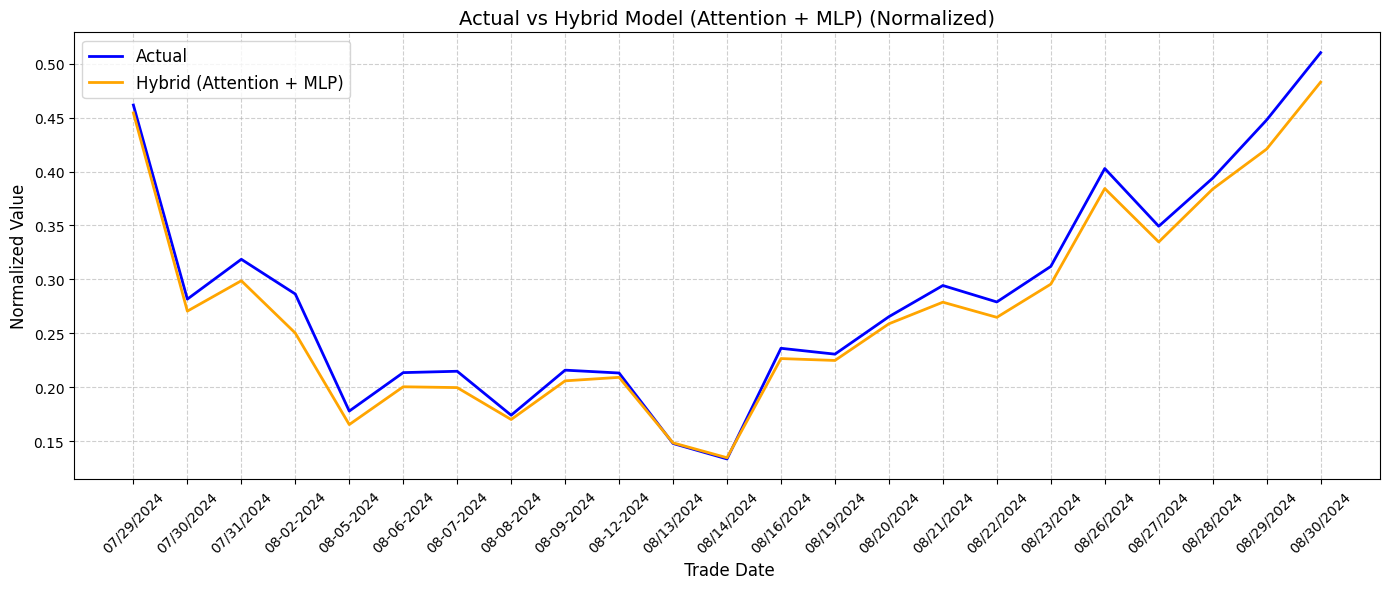

In [23]:
# Normalize actual and hybrid predicted values
y_test_norm = (y_test - y_test.min()) / (y_test.max() - y_test.min())
hybrid_preds_test_norm = (hybrid_preds_test - hybrid_preds_test.min()) / (hybrid_preds_test.max() - hybrid_preds_test.min())

# Prepare the date index (last len(y_test) dates from your dataset)
dates = data['Trade Date'][-len(y_test):].reset_index(drop=True)

# Create DataFrame for plotting
hybrid_plot_df = pd.DataFrame({
    'Trade Date': dates,
    'Actual': y_test_norm.reset_index(drop=True),
    'Hybrid (Attention + MLP)': hybrid_preds_test_norm
})

# Group by Date (if duplicates) and take mean
hybrid_plot_df = hybrid_plot_df.groupby('Trade Date').mean().reset_index()

# Plot Actual vs Hybrid Model
plt.figure(figsize=(14, 6))  # Wider figure
plt.plot(hybrid_plot_df['Trade Date'], hybrid_plot_df['Actual'], label='Actual', color='blue', linewidth=2)
plt.plot(hybrid_plot_df['Trade Date'], hybrid_plot_df['Hybrid (Attention + MLP)'], label='Hybrid (Attention + MLP)', color='orange', linewidth=2)
plt.xlabel(' Trade Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Actual vs Hybrid Model (Attention + MLP) (Normalized)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 233489.9844 - mae: 375.9489 - val_loss: 145251.3750 - val_mae: 310.3127
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 200696.7031 - mae: 342.1658 - val_loss: 50889.4961 - val_mae: 178.0191
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 58618.6992 - mae: 168.0270 - val_loss: 19064.4395 - val_mae: 106.1889
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 17910.4844 - mae: 89.1050 - val_loss: 11754.1885 - val_mae: 86.0299
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11585.7383 - mae: 76.1402 - val_loss: 9350.2236 - val_mae: 76.9989
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14892.4502 - mae: 76.0285 - val_loss: 10387.6621 - val_mae: 82.6747
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8938.4785 - mae: 63.9544 - val_loss: 7975.3530 - val_mae: 71.5534
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8495.3330 - mae: 65.0789 - val_loss: 8

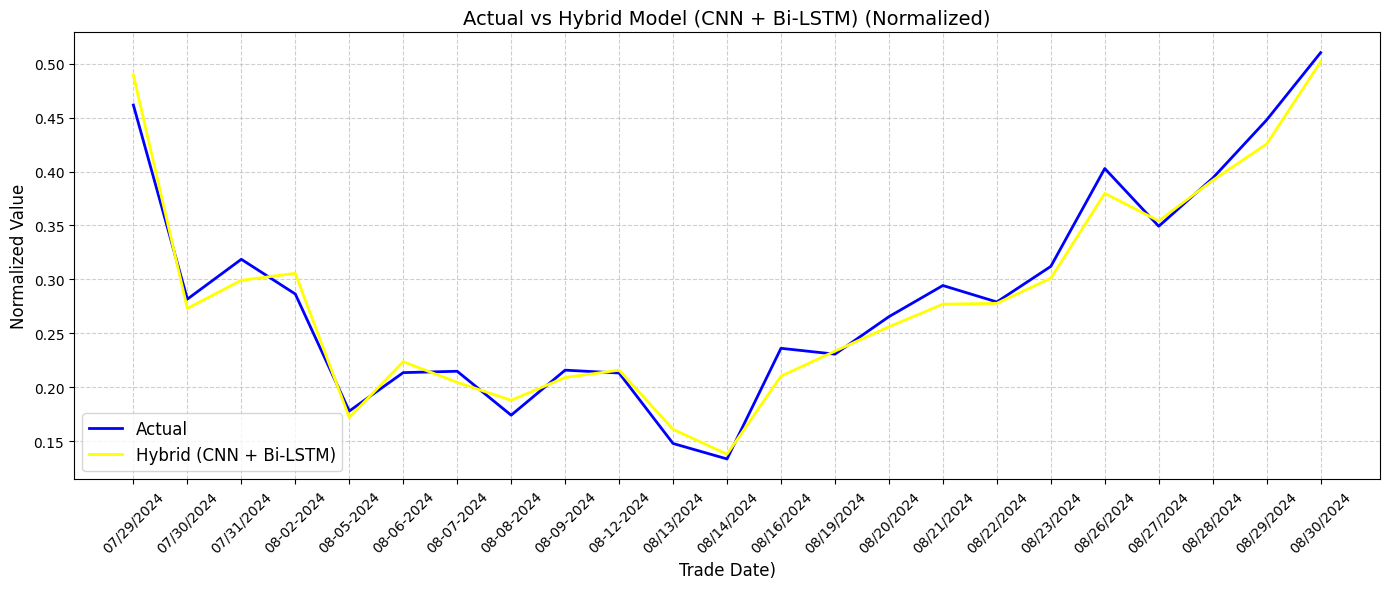

In [24]:
# Reshape inputs for CNN and Bi-LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Input Layer
input_layer = Input(shape=(X_train.shape[1], 1))

# CNN Branch
cnn_branch = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)
cnn_branch = Dense(64, activation='relu')(cnn_branch)

# Bi-LSTM Branch
bilstm_branch = Bidirectional(LSTM(64))(input_layer)
bilstm_branch = Dense(64, activation='relu')(bilstm_branch)

# Early Binding
early_binding = Concatenate()([cnn_branch, bilstm_branch])

# Late Binding Layers
late_binding = Dense(64, activation='relu')(early_binding)
late_binding = Dropout(0.2)(late_binding)

# Output Layer
output_layer = Dense(1)(late_binding)

# Build Model
cnn_bilstm_model = Model(inputs=input_layer, outputs=output_layer)
cnn_bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_cnn_bilstm = cnn_bilstm_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Predictions
cnn_bilstm_preds_test = cnn_bilstm_model.predict(X_test_cnn).ravel()

# Evaluate model
evaluate(y_test, cnn_bilstm_preds_test, "Hybrid Model (CNN + Bi-LSTM)")


# =============================
# Plotting Actual vs Predicted
# =============================


# Normalize actual and CNN-BiLSTM predicted values
y_test_norm = (y_test - y_test.min()) / (y_test.max() - y_test.min())
cnn_bilstm_preds_test_norm = (cnn_bilstm_preds_test - cnn_bilstm_preds_test.min()) / (cnn_bilstm_preds_test.max() - cnn_bilstm_preds_test.min())

# Prepare the date index (last len(y_test) dates from your dataset)
dates = data['Trade Date'][-len(y_test):].reset_index(drop=True)

# Create DataFrame for plotting
cnn_bilstm_plot_df = pd.DataFrame({
    'Trade Date': dates,
    'Actual': y_test_norm.reset_index(drop=True),
    'Hybrid (CNN + Bi-LSTM)': cnn_bilstm_preds_test_norm
})

# Group by Date (if duplicates) and take mean
cnn_bilstm_plot_df = cnn_bilstm_plot_df.groupby('Trade Date').mean().reset_index()

# Plot Actual vs CNN-BiLSTM Model
plt.figure(figsize=(14, 6))  # Wider figure
plt.plot(cnn_bilstm_plot_df['Trade Date'], cnn_bilstm_plot_df['Actual'], label='Actual', color='blue', linewidth=2)
plt.plot(cnn_bilstm_plot_df['Trade Date'], cnn_bilstm_plot_df['Hybrid (CNN + Bi-LSTM)'], label='Hybrid (CNN + Bi-LSTM)', color='yellow', linewidth=2)
plt.xlabel('Trade Date)', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Actual vs Hybrid Model (CNN + Bi-LSTM) (Normalized)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


In [26]:
 from sklearn.linear_model import Ridge

# Predict
train_preds = hybrid_model.predict(X_train).ravel()
test_preds = hybrid_model.predict(X_test).ravel()

#===================== EARLY STACKING (RIDGE) =====================
# Reduced weights for each model in the early stacking
early_stack_train = np.column_stack((
    0.8 * best_xgb_model.predict(X_train),  # Reduced weight for XGBoost predictions
    0.8 * best_nn_model.predict(X_train),  # Reduced weight for NN predictions
    0.8 * train_preds,                    # Reduced weight for hybrid model predictions
    0.8 * cnn_bilstm_model.predict(X_train_cnn),  # Reduced weight for CNN-BiLSTM predictions
    0.8 * train_preds                      # Repeated reduced hybrid model predictions
))

# Reduced weights for the early stacking test predictions
early_stack_test = np.column_stack((
    0.8 * xgb_preds_test,  # Reduced weight for XGBoost predictions
    0.8 * nn_preds_test,   # Reduced weight for NN predictions
    0.8 * hybrid_preds_test,  # Reduced weight for hybrid model predictions
    0.8 * cnn_bilstm_preds_test,  # Reduced weight for CNN-BiLSTM predictions
    0.8 * test_preds  # Reduced weight for hybrid model predictions
))

ridge_model_early = Ridge(alpha=1.0)
ridge_model_early.fit(early_stack_train, y_train)
early_stack_preds_test = ridge_model_early.predict(early_stack_test)

# ===================== LATE BINDING (WEIGHTED AVERAGING) =====================
# Reduce influence of each model in the late binding weighted averaging
late_binding_preds_test = (0.2 * xgb_preds_test) + (0.2 * nn_preds_test) + (0.2 * cnn_bilstm_preds_test) + (0.2 * hybrid_preds_test)  # Reduced all weights to 0.2

# Evaluation
evaluate(y_test, early_stack_preds_test, "Early Stacking Model")
evaluate(y_test, late_binding_preds_test, "Late Binding Model")



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Early Stacking Model - MAE: 5.7901, RMSE: 7.7604, R^2: 0.9994
Late Binding Model - MAE: 83.9092, RMSE: 107.0439, R^2: 0.8824


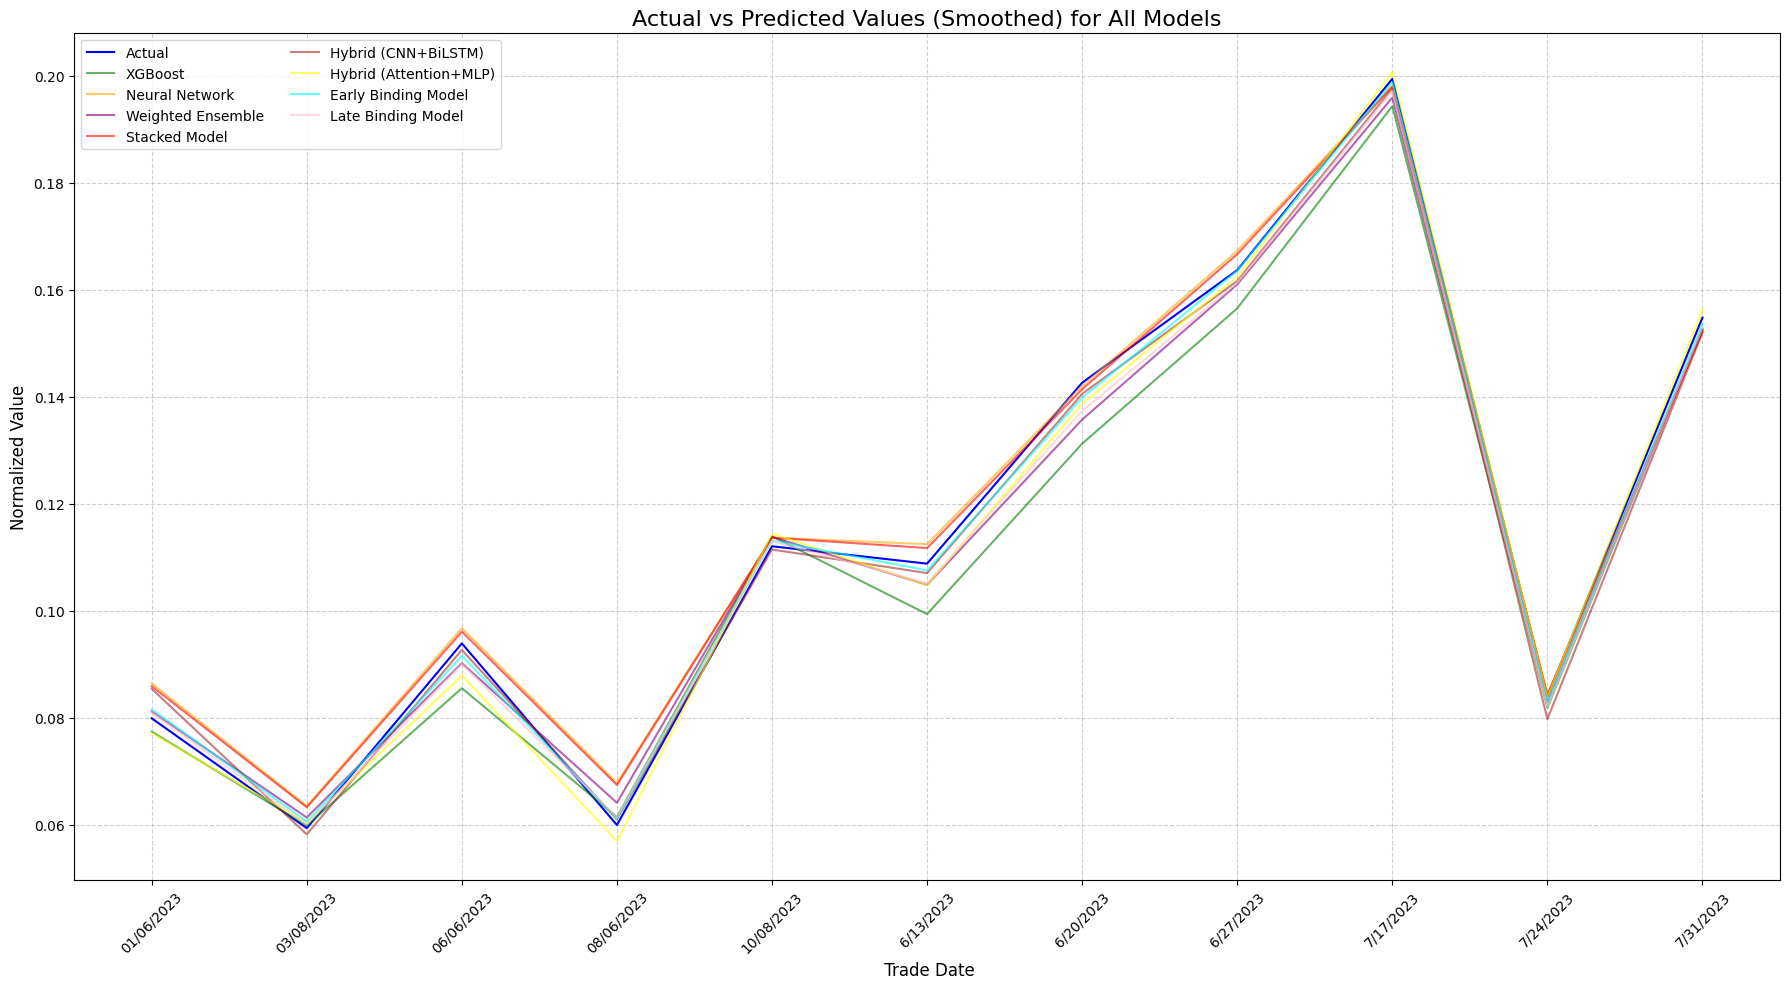

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Normalize actual and all predicted values (already done in your code)
# Plot smoothing with moving average (rolling mean)
window_size = 10  # Increased window size for more smoothing

def smooth(series, window_size):
    # Convert NumPy array to Pandas Series before applying rolling
    if isinstance(series, np.ndarray):
        series = pd.Series(series)
    return series.rolling(window=window_size, min_periods=1).mean()

# Prepare the date index (last len(y_test) dates from your dataset)
dates = data['Trade Date'][-len(y_test):].reset_index(drop=True)

# Create DataFrame for plotting with smoothed values
plot_df = pd.DataFrame({
    'Trade Date': dates,
    'Actual': smooth(y_test_norm.reset_index(drop=True), window_size),
    'XGB': smooth(xgb_preds_test_norm, window_size),
    'NN': smooth(nn_preds_test_norm, window_size),
    'Ensemble': smooth(ensemble_test_preds_norm, window_size),
    'Stacked': smooth(stack_preds_test_norm, window_size),
    'Hybrid (CNN+BiLSTM)': smooth(cnn_bilstm_preds_test_norm, window_size),
    'Hybrid (Attention+MLP)': smooth(hybrid_preds_test_norm, window_size),
    'Early Binding': smooth(early_binding_preds_norm, window_size),
    'Late Binding': smooth(late_binding_preds_norm, window_size)
})

# Group by Date (if duplicates) and take mean
plot_df = plot_df.groupby('Trade Date').mean().reset_index()

# Reduce the number of dates displayed by sampling (show every 5th date for example)
plot_df = plot_df.iloc[::5, :]  # Show every 5th data point

# Plotting
plt.figure(figsize=(18, 10))

# Plot each model with adjusted linewidth and alpha for better readability
plt.plot(plot_df['Trade Date'], plot_df['Actual'], label='Actual', color='blue', linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['XGB'], label='XGBoost', color='green', alpha=0.6, linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['NN'], label='Neural Network', color='orange', alpha=0.6, linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['Ensemble'], label='Weighted Ensemble', color='purple', alpha=0.6, linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['Stacked'], label='Stacked Model', color='red', alpha=0.6, linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['Hybrid (CNN+BiLSTM)'], label='Hybrid (CNN+BiLSTM)', color='brown', alpha=0.6, linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['Hybrid (Attention+MLP)'], label='Hybrid (Attention+MLP)', color='yellow', alpha=0.6, linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['Early Binding'], label='Early Binding Model', color='cyan', alpha=0.6, linewidth=1.5)
plt.plot(plot_df['Trade Date'], plot_df['Late Binding'], label='Late Binding Model', color='pink', alpha=0.6, linewidth=1.5)

# Adding labels and title
plt.xlabel(' Trade Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Actual vs Predicted Values (Smoothed) for All Models', fontsize=16)

# Adding a legend
plt.legend(fontsize=10, loc='upper left', ncol=2)

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)

# Rotate x-ticks for better visibility
plt.xticks(rotation=45)

# Tight layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
